# DSCI 100 Final Project - Heart Disease Classification

DSCI 100 002 Group 10

Group Members: Lily Xie, Eric Ai, William Wang

# Temporary Housekeeping Checklist (To be Removed at the end)

### Questions Needed to be Asked
1. Should we set a different seed for every single box, or it doesn't matter?

2. How to add legend and table number (especially tables)? for plots can we just add it under the x-axis label using xlab?
* in title or another markdown cell.

### Feedback and comment on the project proposal
* Lack of explanations of summary table and graphs. What do you hope readers will gleam from looking at your graphs? Providing commentary on tables/graphs would be a great way of supporting your use of predictors.
* I understand what you're planning on doing for your final visualization, but I don't understand what that has anything to do with your second and third graph? When did age become a factor you were looking at? (deleted)

### Checklist from the project requirement
* describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
* performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
* creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
* performs the data analysis
* creates a visualization of the analysis 
* note: all tables and figure should have a figure/table number and a legend
Discussion:
* summarize what you found
* discuss whether this is what you expected to find?
* discuss what impact could such findings have?
* discuss what future questions could this lead to?
References
* At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
* Make sure to cite the source of your data as well.

### General checklist
1. Include reference and explaination in why we choose the three predictors ("You should have some sort of further evidence to back this up. This should be done with either outside sources or your visualizations.")
2. Fill in the question with our three predictors
3. can set seed in every single code box
4. more explanations of summary tables and graphs (I believe in markdown cells would be better)

* Don't forget to check code format after we finish everything (eg. space, pipe operator, etc.)
* make sure we clean it at the end and only include relevant information and graphs!
* can also add a reference for the discussion - impact part. eg. previous examples of using medical analysis to prevent heart diseases.



## Group Project Requirements (TBD)

just for an easy reference
https://canvas.ubc.ca/courses/83542/assignments/1106464

# Introduction

So Age and Thalach!

Heart disease is a general term that describes several types of heart conditions, and in this dataset, it is shown as the percentage narrowing of blood vessels. In this data set, researchers have collected data from individuals residing in Cleveland, USA. This data set contains 14 attributes of individuals, such as age, biological sex (1 = male; 0 = female), years smoking, serum cholestoral level, resting blood pressure as well as diagnosis of heart disease based on the percentage of blood vessel diameter narrowing ( value of 0 = no, value >=1 = yes). The other 13 attributes may or may not contribute to having heart disease. We have learned that high blood pressure, high cholestorol level and smoking are some of the most common risk factors of heart disease. In this study, we want to explore the relationship between high resting blood pressure along with serum chloesterol levels and the likelihood of having heart disease. 

!!!need to explain why we choose the 2 predictors.Include reference.

The main question we have for this study is: !!! How well does cp, thal and thalach altogether (whatever we choose as our predictors) predict heart disease in Cleveland? (and our answer to the question would be the accuracy of our model) 

To answer this question, we will be using processed.cleveland.data in the heart disease dataset. It includes variables age, sex, types of chest pain (cp), resting blood pressure (trestbps), cholesterol level (chol), fasting blood sugar (fbs), resting electrocardiographic measurement (restecg), max heart rate (thalach), trigger (exang, exercise=1, other= 0), exercise induced depression (oldpeak), slope of the peak exercise ST segment (slope), number of vessels colored by fluoroscopy (ca, ranges from 0-3), thal (3 = normal; 6 = fixed defect; 7 = reversable defect), and diagnosis of heart disease(num). All of the above factors may or may not affect the chance of having heart disease. In order to perform our data analysis, we need to further wrangle the data as shown below.


# Preliminary Explorotary Data Analysis

In [32]:
set.seed(2022)

options(repr.matrix.max.rows = 20)
library(repr)
library(tidyverse)
library(tidymodels)
library(dplyr) 
options(repr.matrix.max.rows = 8)

Warning message:
“package ‘cowplot’ was built under R version 4.0.3”


As we download the file processed_cleveland.data and opened it in a text editor, we can see that all the variables for observations are separated by commas. We can go ahead and read in the dataset using read_csv, and call cleveland_data_raw to see what the dataset looks like.

In [5]:
set.seed(2022)
cleveland_data_raw <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = FALSE)
cleveland_data_raw

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)



X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,2
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


As shown on the table, the data set follows the criterion for tidy data: each variable forms a column, each observation forms a row, and each cell is a single measurement. The only element missing is the column titles, and we can manually assign them according to the data description on the web.


In [6]:
set.seed(2022)
cleveland_data =cleveland_data_raw %>%
rename (age = X1 ,sex = X2,cp= X3,trestbps = X4 
        ,chol= X5,fbs = X6,restecg = X7,thalach = X8
        ,exang = X9,oldpeak = X10,slope = X11,ca = X12,
        thal = X13,num = X14)
cleveland_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,2
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


Just for clarification, here are what all the column names representing:

1. age: age in years
2. sex: sex (1 = male; 0 = female)
3. cp: chest pain type
       -- Value 1: typical angina
       -- Value 2: atypical angina
       -- Value 3: non-anginal pain
       -- Value 4: asymptomatic
4. trestbps: resting blood pressure (in mm Hg on admission to the hospital)
5. chol: serum cholestoral in mg/dl
6. fbs: fasting blood sugar > 120 mg/dl, (1 = true; 0 = false)
7. restecg: resting electrocardiographic results
       -- Value 0: normal
       -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
       -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
8. thalach: maximum heart rate achieved
9. exang: exercise induced angina (1 = yes; 0 = no)
10. oldpeak: ST depression induced by exercise relative to rest
11. slope: the slope of the peak exercise ST segment
       -- Value 1: upsloping
       -- Value 2: flat
       -- Value 3: downsloping
12. ca: number of major vessels (0-3) colored by flourosopy
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
14. num: diagnosis of heart disease (angiographic disease status)
       -- Value 0: < 50% diameter narrowing
       -- Value 1: > 50% diameter narrowing

Note that "num" is also the predicted attribute in our data analysis.

To better perform the data analysis, we need to wrangle the data a bit more. As mentioned in the description of the data set, there are only 2 distinct levels in blood vessel narrowing levels:  Value 0 indicates < 50% diameter narrowing, and Value 1 indicates > 50% diameter narrowing. Therefore , we converted num values >=1 all into 2 and values of 0 all into 1 (because if we keep 0 as no heart disease, it creates trouble in later data analysis). so that there are only two classes: 1 = no heart disease, 2 = have heart disease. We also standardize the column value for resting blood pressure, serel chloestoral level and age so that they all contribute equally to the k-nearest neighbour prediction

In [7]:
set.seed(2022)
#Cleaning and wrangling
#turn 1 2 3 4 into 1 
cleveland_data_clean = mutate(cleveland_data, num = ifelse(num >= 1 , 1, 0) )%>%
#remove row with missing value 
 filter_all( all_vars(!(.  %in% c('?'))))%>%


# change num into a factor and change chracter data type into numeric data type for later analysis
mutate(num= as_factor(num), thal= as.double(thal), ca= as.double(ca))


cleveland_data_clean

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,1,1,110,264,0,0,132,0,1.2,2,0,7,1
68,1,4,144,193,1,0,141,0,3.4,2,2,7,1
57,1,4,130,131,0,0,115,1,1.2,2,1,7,1
57,0,2,130,236,0,2,174,0,0.0,2,1,3,1


Quick Note: 1 is with hd, 0 is without.

## Spliting for Training and Testing Sets


In [8]:
set.seed(2022)
#spliting the dataset into training and testing sets
cleveland_split <- initial_split(cleveland_data_clean, prop = 0.75, strata = num)  
cleveland_training <- training(cleveland_split)
cleveland_testing <- testing(cleveland_split)

## Training Data Predictor Data Plot

!!! need to change Below we show the distribution of standardized resting blood pressure and serum cholesterol level in the scatter plot with color code indicating the presence of heart disease, and it is also a sample visualization of how our project will look like.

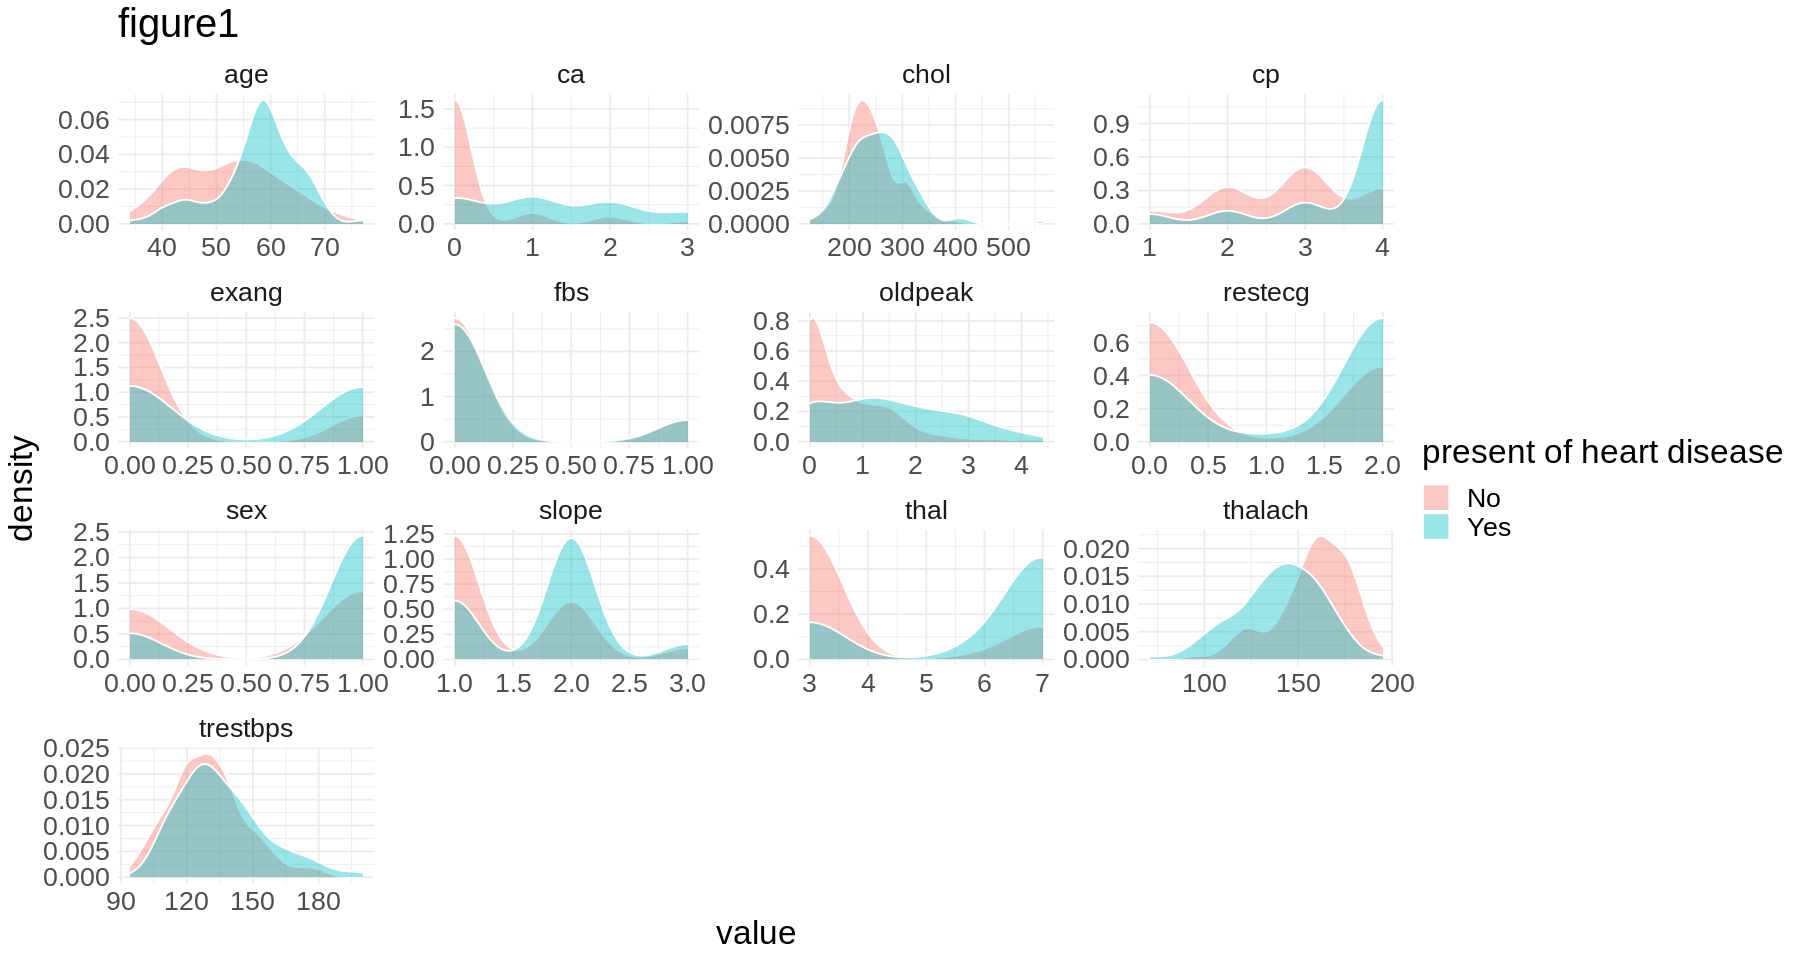

In [9]:
set.seed(2022)
cleveland_data_training_mutate= cleveland_training %>%
mutate(ca = as.numeric(ca), thal = as.numeric(thal))

options(repr.plot.height = 8, repr.plot.width = 15)
cleveland_data_training_mutate %>%
    pivot_longer(cols = -num, names_to = 'category', values_to = 'value')  %>% 
    ggplot(aes(value, fill = num)) +
        geom_density(alpha = 0.4, colour = 'white') +
        facet_wrap(~ category, scales = 'free') +
        theme_minimal() +
        theme(text = element_text(size = 20))+
scale_fill_discrete(name='present of heart disease',labels=c("No", "Yes"))+
ggtitle("figure1")

!!! Add explanations on why we choose age and thalach as our predictors (state that we cannot perform classification on categorical variables, these two are the one that are numeric and most distinct from the graph above, etc.)

## Training Data Summary

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



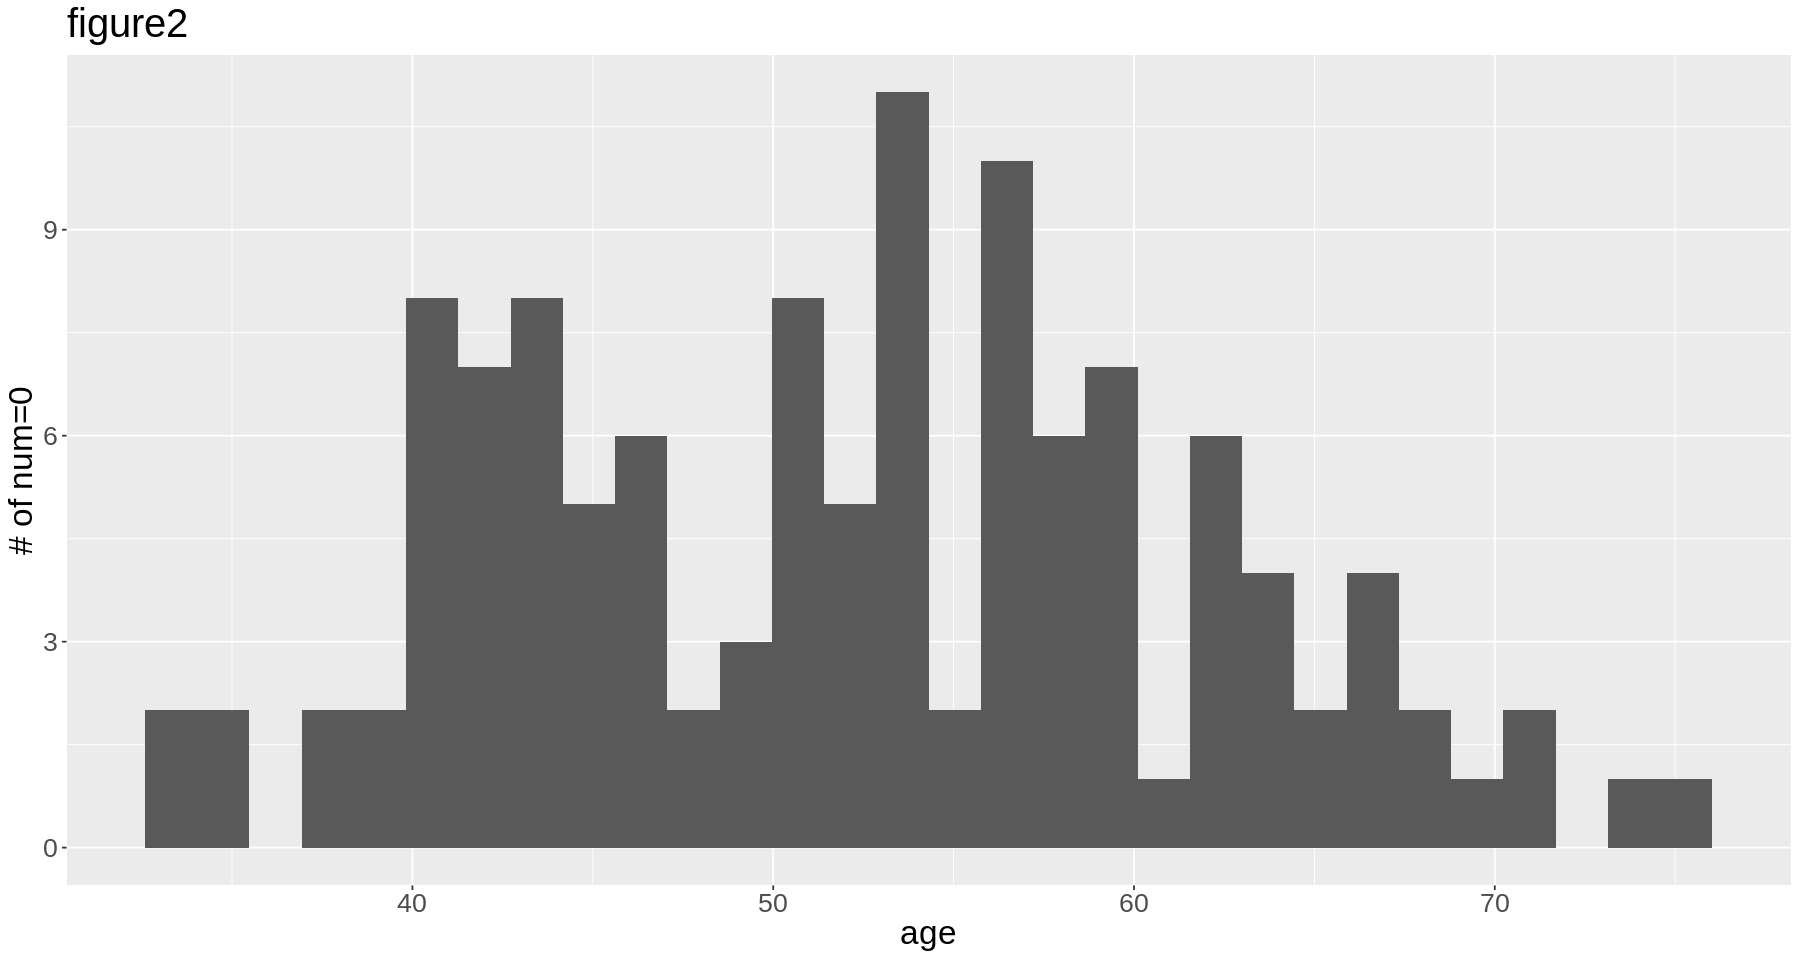

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



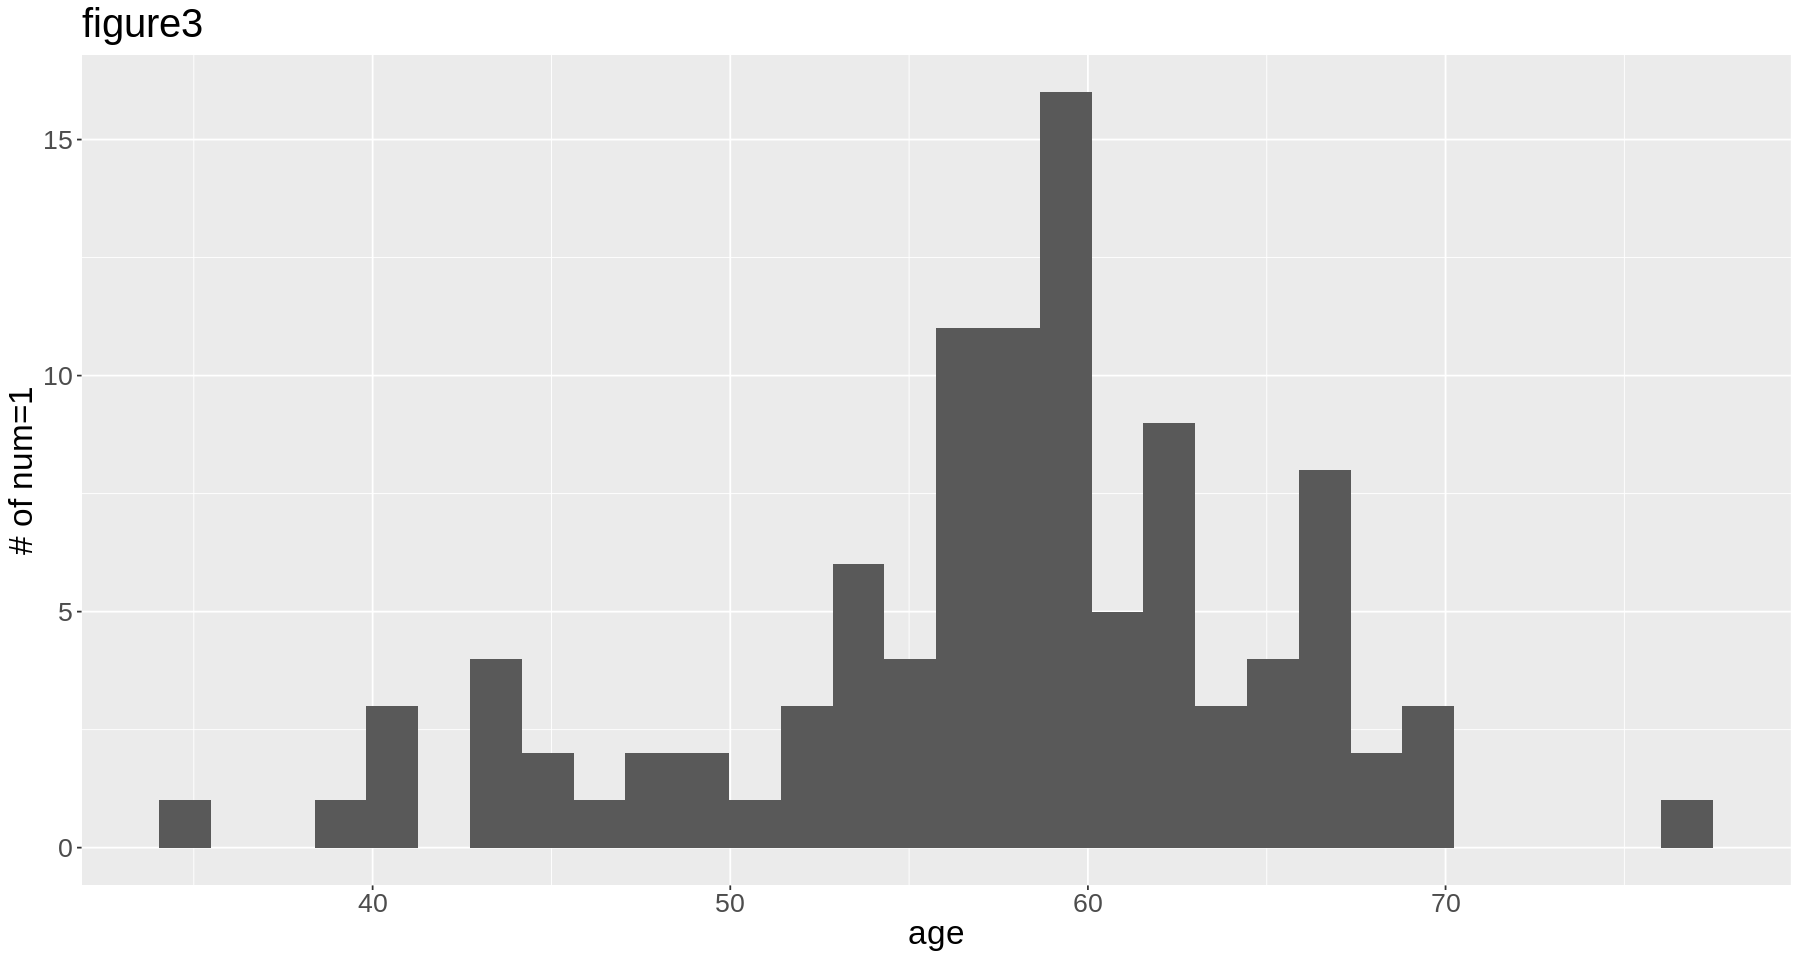

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



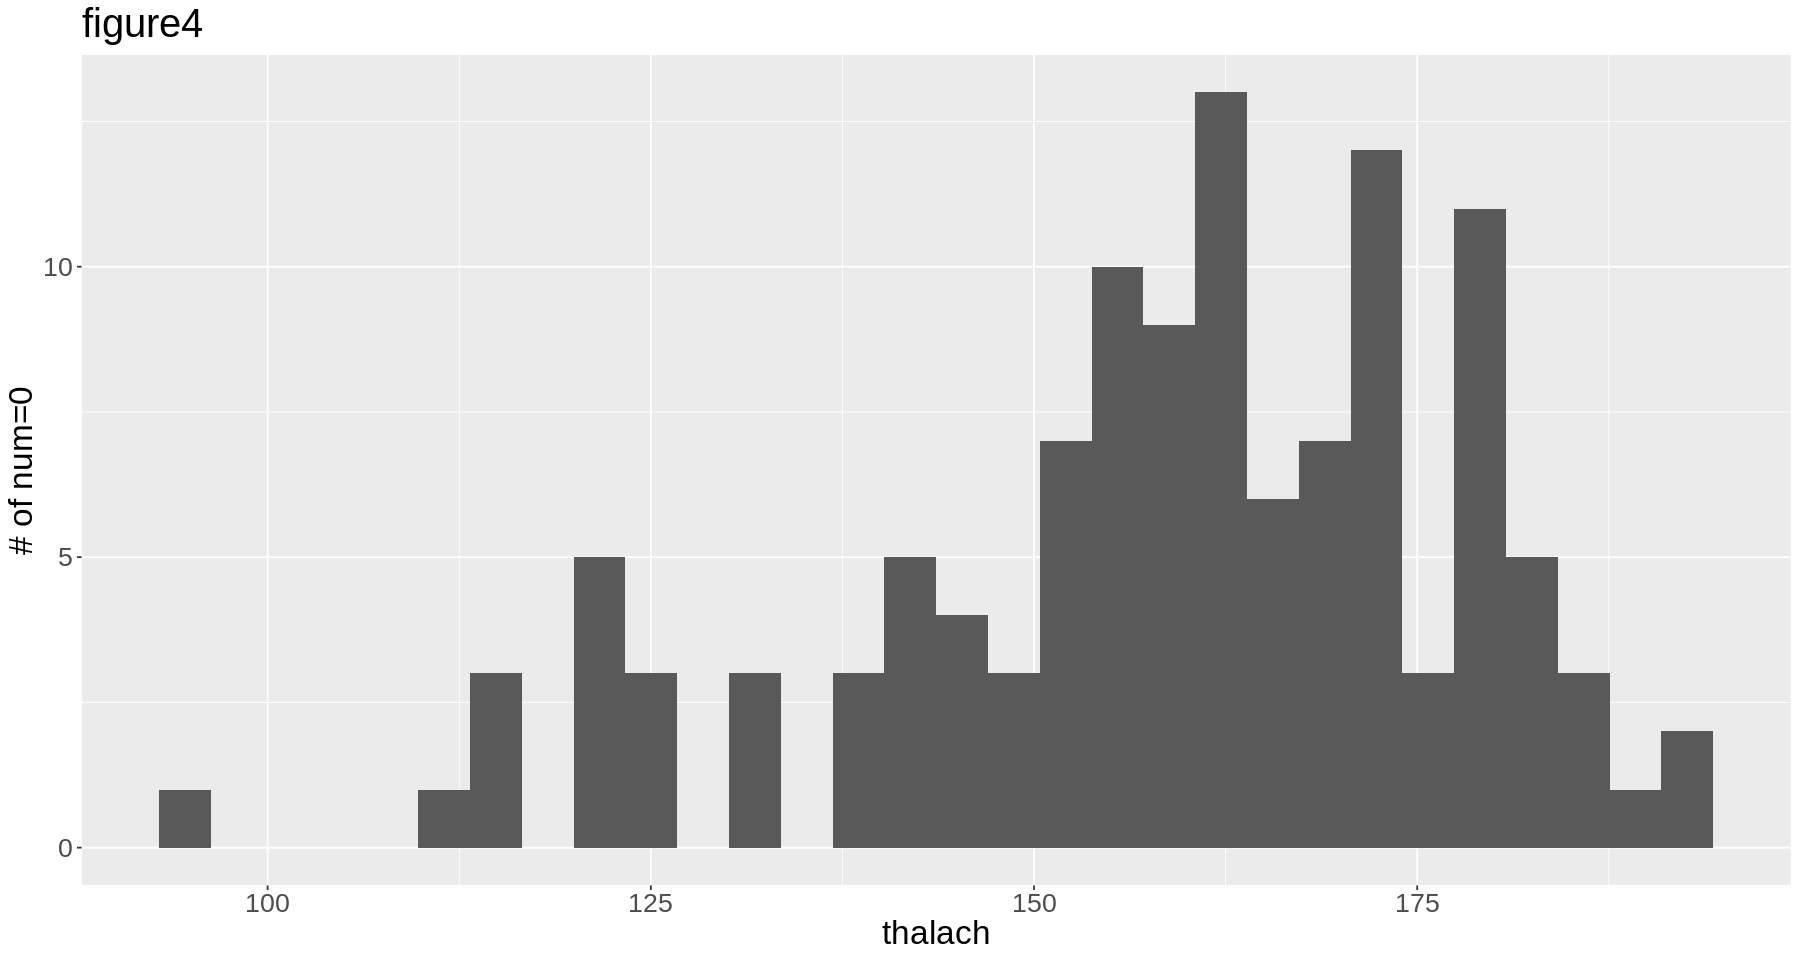

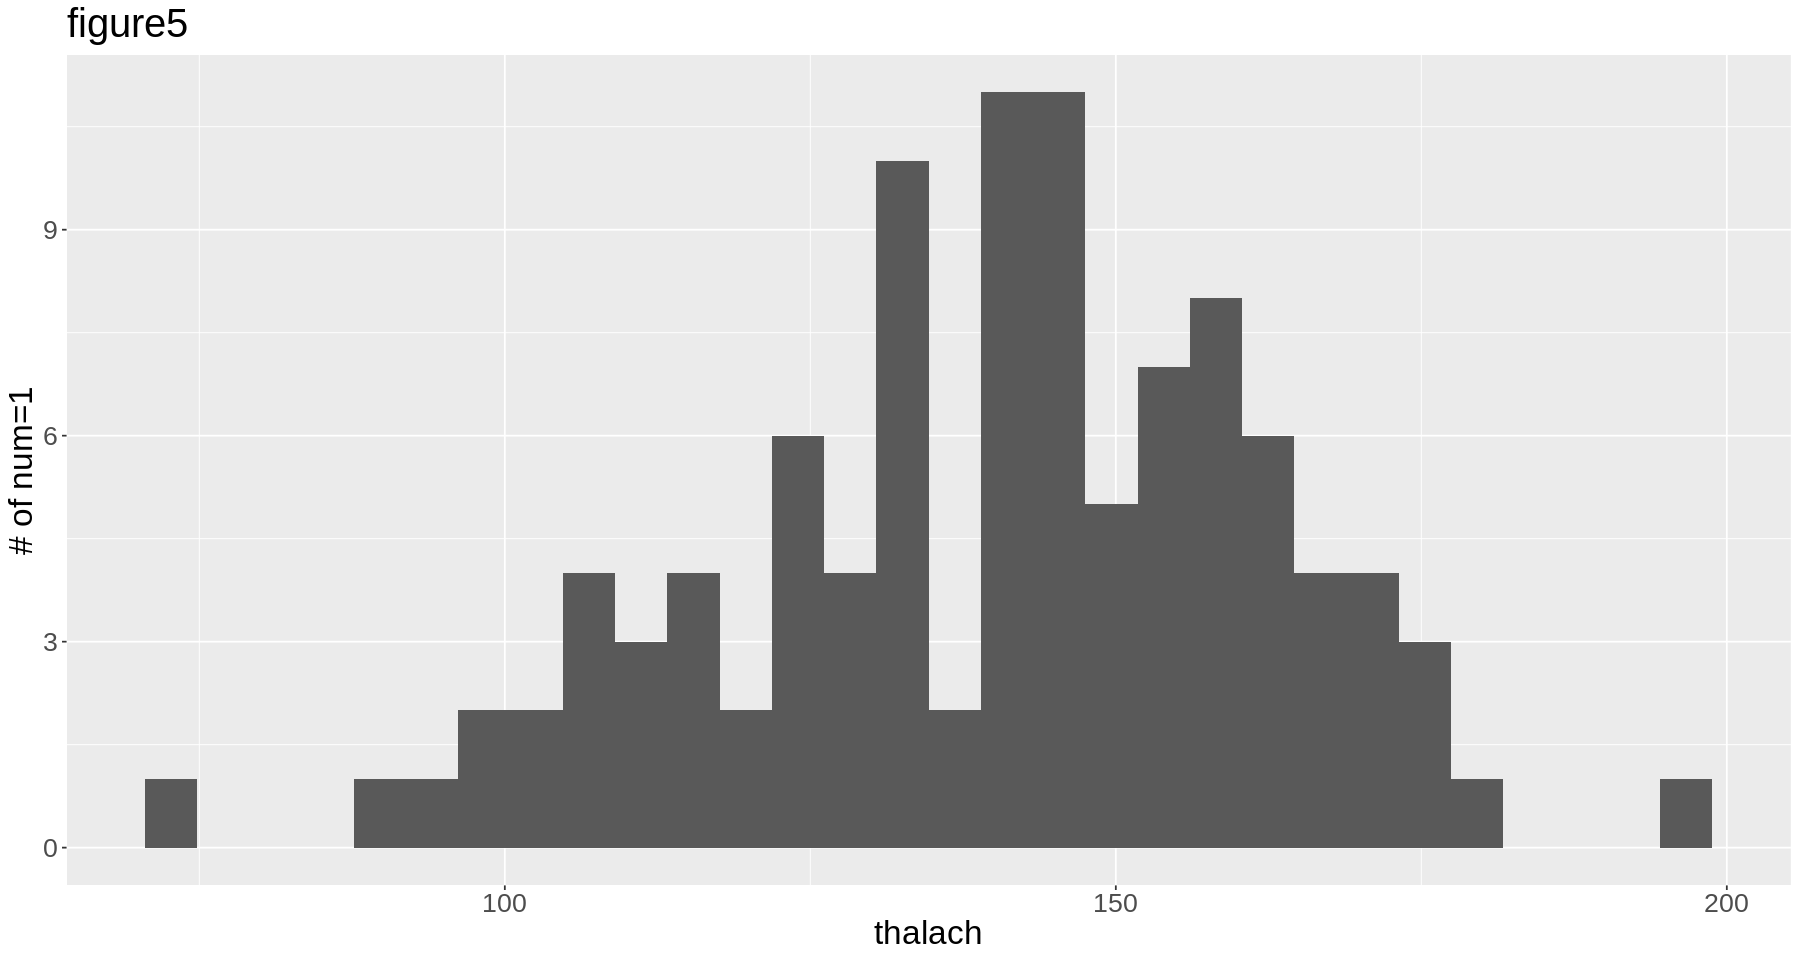

In [10]:
plot_age_0<-cleveland_training%>%
filter(num==0)%>%
ggplot(aes(x = age,)) + 
   geom_histogram() +
    labs(x= "age", y= "# of num=0")+
    theme(text = element_text(size=20))+
    ggtitle("figure2 ")
plot_age_0

plot_age_1<-cleveland_training%>%
filter(num==1)%>%
ggplot(aes(x = age,)) + 
   geom_histogram() +
    labs(x= "age", y= "# of num=1")+
    theme(text = element_text(size=20))+
    ggtitle("figure3 ")
plot_age_1


plot_thalach_0<-cleveland_training%>%
filter(num==0)%>%
ggplot(aes(x = thalach,)) + 
   geom_histogram() +
    labs(x= "thalach", y= "# of num=0")+
    theme(text = element_text(size=20))+
    ggtitle("figure4 ")
plot_thalach_0

plot_thalach_1<-cleveland_training%>%
filter(num==1)%>%
ggplot(aes(x = thalach,)) + 
   geom_histogram() +
    labs(x= "thalach", y= "# of num=1")+
    theme(text = element_text(size=20))+
    ggtitle("figure5 ")
plot_thalach_1




In [11]:
#summary and mean values
set.seed(2022)

#missing values are removed in the cleaning process (6 missing values in total)


# cleveland_training %>%
# group_by(num)%>%
# summarize(n=n())

# cleveland_training %>%
# summarize(n=n())



# cleveland_training %>%
# mutate (avg_age = mean(age),  
#        avg_thalach = mean(thalach))%>%
# select (avg_age ,avg_thalach)%>%
# slice (1)


# cleveland_training %>%
# filter(num == 0)%>%
# mutate (avg_age_nohd = mean(age),  
#        avg_thalach_nohd = mean(thalach))%>%
# select (avg_age_nohd ,avg_thalach_nohd)%>%
# slice (1)

# cleveland_training %>%
# filter(num == 1)%>%
# mutate (avg_age_hd = mean(age),  
#        avg_thalach_hd = mean(thalach))%>%
# select (avg_age_hd ,avg_thalach_hd)%>%
# slice (1)


# ↑where we get our value for the table 
sum_table <- data.frame(without_hd = 120, with_hd =103, n_of_row = 223,
                        avg_age = 54.81614, avg_age_nohd = 52.40833 ,avg_age_hd =57.62136, 
                        avg_thalach =150.1883, avg_thalach_nohd= 158.6333 ,  avg_thalach_hd= 140.3495)
sum_table

without_hd,with_hd,n_of_row,avg_age,avg_age_nohd,avg_age_hd,avg_thalach,avg_thalach_nohd,avg_thalach_hd
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
120,103,223,54.81614,52.40833,57.62136,150.1883,158.6333,140.3495


<i>table 1</i>

# Method 

We hypothesize that resting blood pressure and serum chloestoral levels are most related to heart disease, so We will use the two columns “trestbps” and “chol”, as well as num (have / don’t have heart disease) in our data analysis.


We plan to use scatter plots to visualize our results, with two factors on each axis, and possibly different colored regions to indicate whether the data points have heart disease.


# Expected Outcomes and Significance


We expect to find that resting blood pressure and serum cholesteral level together correlate with heart disease: they would possibly have a strong/medium positive correlation with the likelihood of having heart disease, and we speculate that these factors might amplify the effect of each other (that is, people with high levels in both factors are more likely to have heart disease). Once we conduct the analysis and obtain our results, we can inform related public health agencies about our conclusion and promote healthy actions. For example, if we found cholesterol is contributing strongly to heart disease (strong correlation), then this finding can inspire the health department to promote healthy diet in the public, such as eating food with less serum cholesterol levels. Future questions can be and not limited to: what attributes or behaviours are correlated with high resting blood pressure/cholestrol level, given a patient’s blood pressure and cholestrol level, can we predict if they have heart disease, etc.




In this project proposal, we have outlined the main question and procedure of our data analysis. We will continue conducting the study on predicting heart disease, and we hope to create a meaningful and thoughtful data analysis moving on.



mean,neighbors
<dbl>,<int>
0.6998024,10


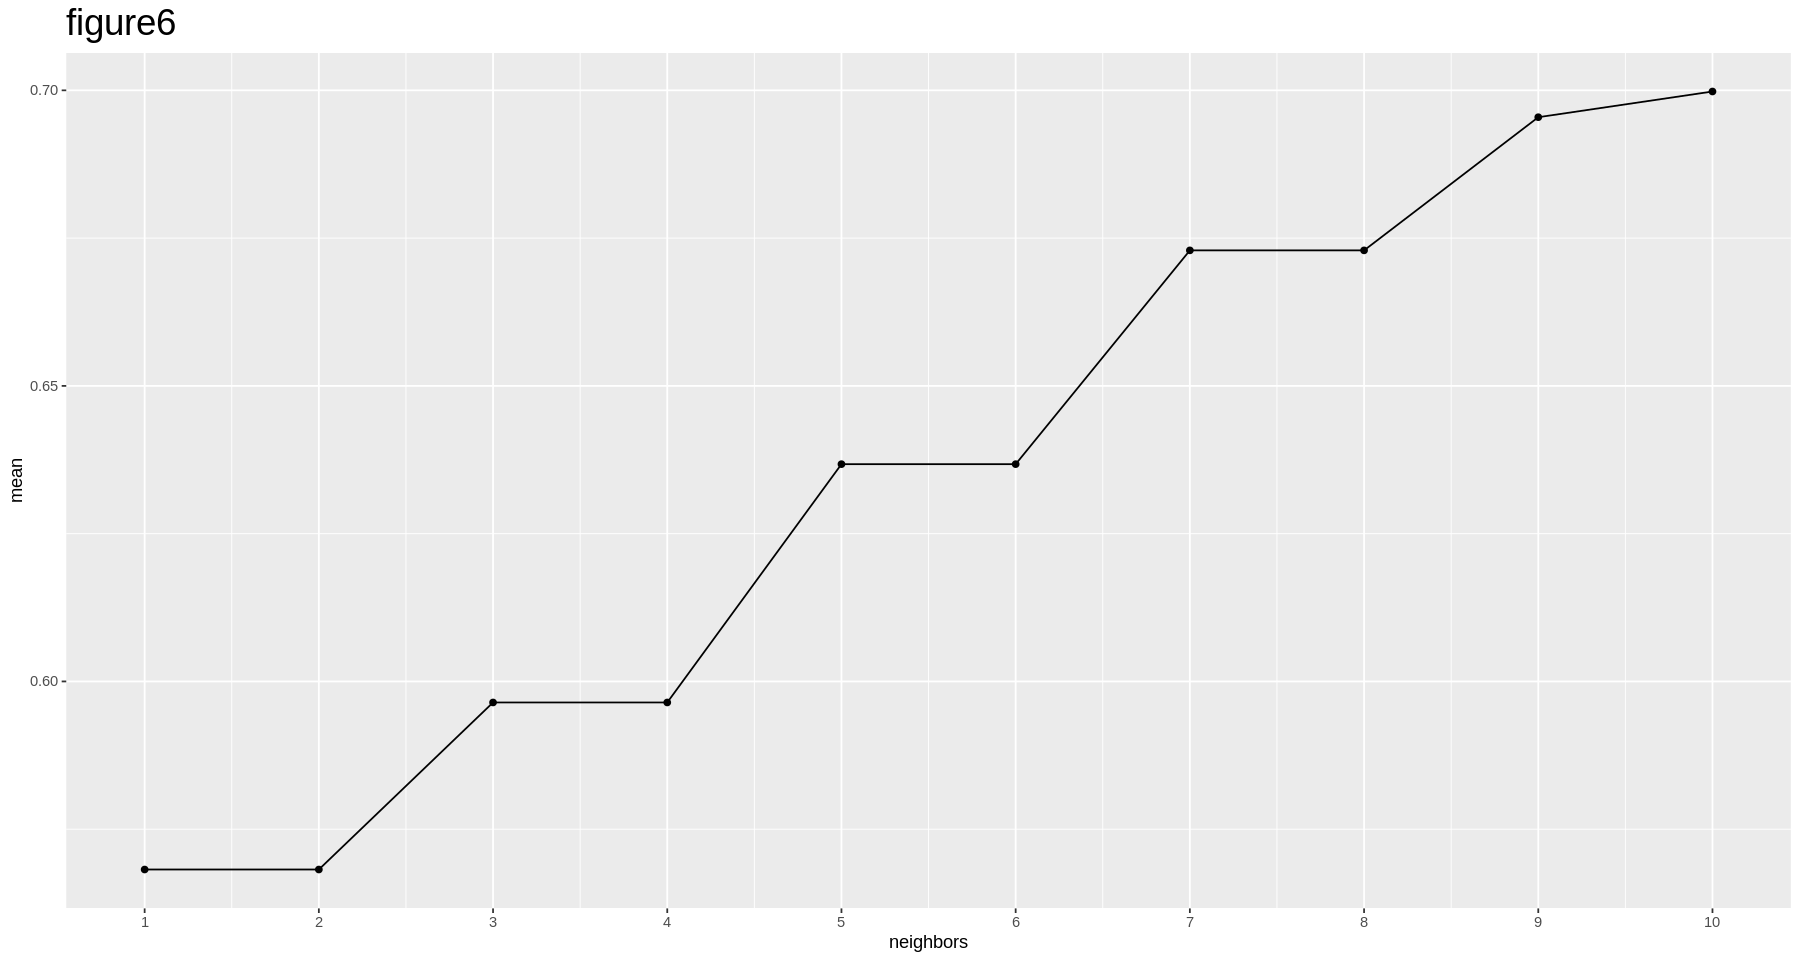

In [30]:
set.seed(2022)

vrecipe <- recipe(num~ age + thalach , data = cleveland_training)%>%
  step_scale(all_numeric()) %>%
    step_center(all_numeric())

vfold <- vfold_cv( cleveland_training, v = 10, strata = num)
knn_tune= nearest_neighbor(weight_func = "rectangular", neighbors = tune() )%>%
    set_engine("kknn")%>%
    set_mode("classification")

gridvals <- tibble(neighbors = seq(from = 1, to = 10))
knn_results <- workflow() %>%
       add_recipe(vrecipe) %>%
       add_model(knn_tune) %>%
       tune_grid(resamples = vfold, grid = gridvals) %>%
       collect_metrics()

accuracies <- knn_results %>% 
        filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       ggtitle("figure6")+
       scale_x_continuous(breaks = c(0, 1, 2, 3,4,5,6,7,8,9,10))+
       theme(plot.title = element_text(size=22))

cross_val_plot 
#determine the neighbor number
best_neightbors <- accuracies%>%
arrange(neighbors)%>%
select(mean, neighbors)%>%
arrange(desc(mean))%>%
slice(1)
best_neightbors

In [34]:
set.seed(2022)

cleveland_recipe <- recipe(num ~age  + thalach , data = cleveland_training)%>%
  step_scale(all_predictors()) %>%
    step_center(all_predictors())


mnist_spec <- nearest_neighbor(weight_func = "rectangular", neighbors =14) %>%
    set_engine("kknn") %>%
    set_mode("classification")

mnist_fit <- workflow() %>%
        add_recipe(cleveland_recipe)%>%
        add_model(mnist_spec) %>%
        fit(data = cleveland_training)

mnist_predictions <- predict (mnist_fit, cleveland_testing) %>%
    bind_cols(cleveland_testing)

mnist_metrics <- mnist_predictions %>%
    metrics(truth = num, estimate = .pred_class)%>%
filter(.metric == "accuracy")
mnist_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7162162
